In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import liana as li
from liana.method._pipe_utils._common import _get_props
from liana.method.sp._utils import _add_complexes_to_var
from liana._logging import _logg
from liana.method._pipe_utils import prep_check_adata, assert_covered
from scipy.sparse import csr_matrix

# note squidpy is needed for autocorrelation / svgs
import squidpy as sq

In [50]:
resource = li.rs.select_resource('cellchatdb')
import requests
import io

In [51]:
adata = sc.read_h5ad("nanostring_cosmx_human_nsclc_batch8.h5ad")
li.ut.spatial_neighbors(adata=adata, bandwidth=100)

In [52]:
sq.gr.spatial_autocorr(adata, mode='moran', use_raw=False)
# NOTE: this is basically useless xD, 95% of genes are autocorrelated

In [53]:
# NOTE: use some arbitrary I to actually filter, p-values for such metrics are useless imo
# NOTE: @Moeed, if you are to use SVGs, I would recommend using a union of SVGs across all slides - you would need the same gene names across all slides (also same LRs, tbd)
svgs = adata.uns['moranI'].index[(adata.uns['moranI']['pval_norm_fdr_bh'] < 0.05) & (adata.uns['moranI']['I'] > 0.01)]
adata = adata[:, svgs]

In [54]:
nz_prop = 0.001 # NOTE @Moeed this will like introduce differences between LRs across slides, you would need to concat the lrdatas across slides and fill Nones as 0s
x_name = 'ligand'
y_name = 'receptor'
complex_sep = '_'
xy_sep = '^'
verbose = True


def _rename_means(lr_stats, entity):
    df = lr_stats.copy()
    df.columns = df.columns.map(lambda x: entity + '_' + str(x) if x != 'gene' else 'gene')
    return df.rename(columns={'gene': entity})

if complex_sep is not None:
    adata = _add_complexes_to_var(adata,
                                    np.union1d(resource[x_name].astype(str),
                                                resource[y_name].astype(str)
                                                ),
                                    complex_sep=complex_sep
                                    )

# filter_resource
resource = resource[(np.isin(resource[x_name], adata.var_names)) &
                    (np.isin(resource[y_name], adata.var_names))]

# get entities
entities = np.union1d(np.unique(resource[x_name]),
                        np.unique(resource[y_name]))
assert_covered(entities, adata.var_names, verbose=verbose)

# Filter to only include the relevant features
adata = adata[:, np.intersect1d(entities, adata.var.index)]

xy_stats = pd.DataFrame({'means': adata.X.mean(axis=0).A.flatten(), # NOTE: this A should be changed toarray)
                        'props': _get_props(adata.X)},
                        index=adata.var_names
                        ).reset_index().rename(columns={'index': 'gene'})
# join global stats to LRs from resource
xy_stats = resource.merge(_rename_means(xy_stats, entity=x_name)).merge(
                            _rename_means(xy_stats, entity=y_name))

# filter according to props
xy_stats = xy_stats[(xy_stats[f'{x_name}_props'] >= nz_prop) &
                    (xy_stats[f'{y_name}_props'] >= nz_prop)]
if xy_stats.empty:
    raise ValueError("No features with non-zero proportions")

# create interaction column
xy_stats['interaction'] = xy_stats[x_name] + xy_sep + xy_stats[y_name]

x_mat = adata[:, xy_stats[x_name]].X
y_mat = adata[:, xy_stats[y_name]].X

In [55]:
groupby = 'cell_type'

In [56]:
celltypes = pd.get_dummies(adata.obs[groupby])
ct = csr_matrix(celltypes.astype(int).values)

In [57]:
k = ct.shape[1] # number of cell types
m = x_mat.shape[1] # number of LRs
w = adata.obsp['spatial_connectivities'] # spatial weights

In [58]:
l = np.expand_dims(x_mat.toarray(), axis=1)
s = np.expand_dims(ct.toarray(), axis=2)
ls = np.multiply(l, s)
ls = ls.reshape((ls.shape[0], m * k))
# transform
ls = li.utils.zi_minmax(ls, cutoff=0.01).toarray()
wls = w.dot(csr_matrix(ls)).toarray()
# normalize by the sum of the weights (to bring back to same scale as the original data)
wls = wls / w.sum(axis=1)
wls[np.isnan(wls)] = 0 # nans are introduced by division by zero

/tmp/ipykernel_2186293/2214387085.py:9: RuntimeWarning: invalid value encountered in divide


In [59]:
# transform
r =  li.utils.zi_minmax(y_mat, cutoff=0.01).toarray()
ri = np.tile(r, ct.shape[1])
xy_mat = np.array(wls) * ri

In [60]:
var = pd.DataFrame(index=(
    np.repeat(celltypes.columns.astype(str), m) +
    xy_sep + 
    np.tile(xy_stats['interaction'].astype(str), k)
    ))

In [61]:
lrdata = sc.AnnData(X=xy_mat, var=var, obs=adata.obs, uns=adata.uns, obsm=adata.obsm, varm=adata.varm, obsp=adata.obsp)
lrdata.shape

(76536, 1780)

In [62]:
sc.pp.highly_variable_genes(lrdata)
lrdata.var[lrdata.var['highly_variable']] # not accurate - just to check

,highly_variable,means,dispersions,dispersions_norm
myeloid^SPP1^CD44,True,0.035672,-1.304811,1.000000
myeloid^HLA-DRA^CD4,True,0.013669,-1.717211,0.555819
myeloid^HLA-DRB1^CD4,True,0.015320,-1.621668,1.337621
tumor^AREG^EGFR,True,0.027102,-1.559469,1.138968
tumor^APP^CD74,True,0.070437,-2.121324,1.000000
tumor^MIF^CD44_CD74,True,0.030131,-1.601954,1.000000
tumor^FN1^ITGA3_ITGB1,True,0.016601,-1.607364,1.385027
tumor^COL1A1^ITGA3_ITGB1,True,0.020519,-1.493163,1.427207
tumor^COL6A1^ITGA3_ITGB1,True,0.016492,-1.694826,1.095162
tumor^COL6A2^ITGA3_ITGB1,True,0.024253,-1.359429,1.095227


In [63]:
adata.layers['transformed'] = li.utils.zi_minmax(adata.X, cutoff=0.01)

/tmp/ipykernel_2186293/3987365680.py:1: ImplicitModificationWarning: Setting element `.layers['transformed']` of view, initializing view as actual.


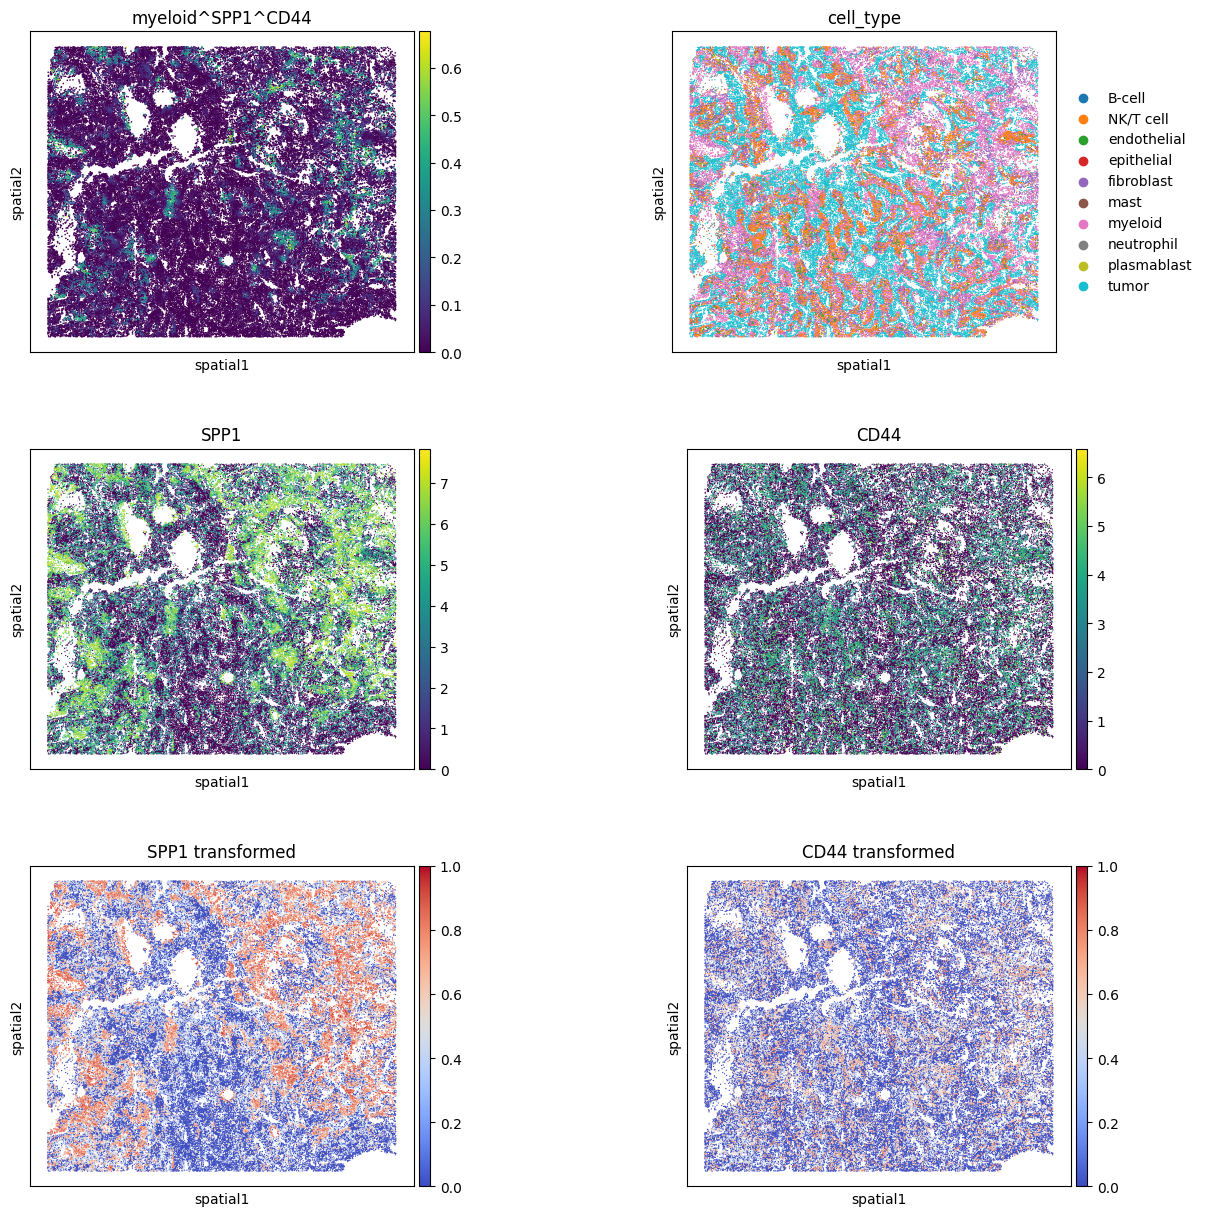

In [64]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axes = axes.flatten()

# Define your keys
key = 'myeloid^SPP1^CD44' #NOTE @Moeed, sanity check interaction for Macrophage infiltration
keys = key.split(xy_sep)

if len(keys) < 2:
    raise ValueError("The 'key' variable should contain at least two elements separated by '&'.")

ligand = keys[1]
receptor = keys[2]

adata.obs['receptor'] = (adata[:, receptor].X > 0).toarray().flatten()

sc.pl.spatial(lrdata, color=[key], spot_size=100, ax=axes[0],show=False)
axes[0].set_title(f"{key}")
sc.pl.spatial(adata, color=[groupby], spot_size=80, ax=axes[1],show=False)
axes[1].set_title(f"{groupby}")
sc.pl.spatial(adata, color=[ligand], spot_size=80, ax=axes[2], show=False)
axes[2].set_title(f"{ligand}")
sc.pl.spatial(adata, color=[receptor], spot_size=80, ax=axes[3], show=False)
axes[3].set_title(f"{receptor}")
sc.pl.spatial(adata, color=[ligand], spot_size=80, ax=axes[4], show=False, layer='transformed', cmap='coolwarm')
axes[4].set_title(f"{ligand} transformed")
sc.pl.spatial(adata, color=[receptor], spot_size=80, ax=axes[5], show=False, layer='transformed', cmap='coolwarm')
axes[5].set_title(f"{receptor} transformed")
plt.show()

## Make them global

In [65]:
celltype_names = list(celltypes.columns.values) # k
interaction_names = lrdata.var.index # s x l x r

t = ct.toarray() # k, n
t = t / t.sum(axis=0) # NOTE: scaled by the sum of each cell type

values = (t.T @ lrdata.X) # k x (s*l*r); i.e. we sum over n
values = values.flatten()

df = pd.DataFrame({
    'name': np.tile(interaction_names, k)+ xy_sep + np.repeat(celltype_names, interaction_names.shape[0]),
    'value': values
})

In [69]:
df.sort_values('value').tail(20)

,name,value
9706,fibroblast^FN1^CD44^mast,0.039189
9704,fibroblast^COL1A2^CD44^mast,0.039231
2041,NK/T cell^COL1A1^CD44^NK/T cell,0.040581
7041,tumor^APP^CD74^epithelial,0.041366
17751,tumor^COL9A2^ITGA3_ITGB1^tumor,0.041637
9161,NK/T cell^COL1A1^CD44^mast,0.042273
17748,tumor^COL6A1^ITGA3_ITGB1^tumor,0.043053
17741,tumor^FN1^ITGA3_ITGB1^tumor,0.043129
17773,tumor^COL6A2^CD44^tumor,0.043249
261,NK/T cell^COL1A1^CD44^B-cell,0.045762


In [67]:
sssss

NameError: name 'sssss' is not defined

### Double Check Broadcasting

In [44]:
lr_names = ['lr1', 'lr2', 'lr3']
ct_names = ['ct1', 'ct2', 'ct3']

# rows are obs, columns are vars
x_mat = np.array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])  # shape (2, 3)
ct = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]])        # shape (2, 2)

k = ct.shape[1]
m = x_mat.shape[1]
n = x_mat.shape[0]

l = np.expand_dims(x_mat, axis=1)  # shape (n, 1, m)
s = np.expand_dims(ct, axis=2)  # shape (n, k, 1)

ls = np.multiply(l, s)  # shape (2, 2, 3)

In [ ]:
ls = ls.reshape((n, m * k))
# np.repeat(ct_names, m) + np.tile(lr_names, k)
var_names = (np.repeat(ct_names, m).astype(list) +
             xy_sep + 
             np.tile(lr_names, k).astype(str)
             )
pd.DataFrame(ls, columns=var_names)

,ct1^lr1,ct1^lr2,ct1^lr3,ct2^lr1,ct2^lr2,ct2^lr3,ct3^lr1,ct3^lr2,ct3^lr3
0,1,2,3,0,0,0,0,0,0
1,0,0,0,4,5,6,0,0,0
2,0,0,0,0,0,0,7,8,9


In [46]:
x_mat.flatten()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

Double check global names

In [47]:
ct_arr = np.array([ # 3 cells, 2 (target) cell types
  [1, 0],  # cell 0: all type A
  [1, 0],  # cell 1: mostly type B
  [1, 0],  # cell 2: half type A, half type B
]) 
lrdata_X = np.array([ # 3 cells, 3 interactions
  [ 10,  20,  30],  # cell 0
  [ 40,  50,  60],  # cell 1
  [ 70,  80,  90],  # cell 2
])

celltype_names = ['TypeA', 'TypeB']
interaction_names = np.array(['I1', 'I2', 'I3'])
ct_sum = ct_arr.sum(axis=1, keepdims=True)
t = ct_arr / ct_sum
values_mat = t.T @ lrdata_X
values = values_mat.flatten()

k = len(celltype_names)
S = len(interaction_names)

name_array = (np.tile(interaction_names, k).astype(list)
              + xy_sep 
              + np.repeat(celltype_names, S))

df = pd.DataFrame({
    'name': name_array,
    'value': values
})

print(df)

       name  value
0  I1^TypeA  120.0
1  I2^TypeA  150.0
2  I3^TypeA  180.0
3  I1^TypeB    0.0
4  I2^TypeB    0.0
5  I3^TypeB    0.0
